# Inside Airbnb 2022 (4 Jan 2022)

### Importing Packages
Here, I am taking the main packages from throughout the practicals as well as some of the functions that Jon uses

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import math

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [2]:
# These are specific to NLP
import nltk
import spacy
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()
mms  = MinMaxScaler(feature_range=(-1,1))
stds = StandardScaler()
rbs  = RobustScaler()
pts  = PowerTransformer()

import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

In [3]:
# This is the Cache Function Jon wrote
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [4]:
# This is the Plotting Function Jon wrote
def plt_ldn(w, b):
    """
    Creates a new figure of a standard size with the 
    water (w) and boundary (b) layers set up for easy
    plotting. Right now this function assumes that you're
    looking at London, but you could parameterise it in
    other ways ot allow it to work for other areas.
    
    w: a water layer for London
    b: a borough (or other) boundary layer for London
    """
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

########################
# These may no longer be relevant because of changes to geopandas API

def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

In [5]:
#This is used in NLP to convert string object to be compatible with markdown
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

### Reading in the Data

In [6]:
listings2022 = pd.read_csv('listings.csv.gz', compression='gzip', low_memory=False)
print(f"Data frame is {listings2022.shape[0]:,} x {listings2022.shape[1]}")

Data frame is 69,351 x 75


### General Data Cleaning: Booleans, Dates, Categories, Price Strings, Geography
Most of this code comes from practical 5

In [7]:
# Here I am parametrising the data by defining the columns so I can work with them more easily. This comes from the FSDS practical 5.
cols = ['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id', 'host_name', 
        'host_since', 'host_location', 'host_about', 'host_is_superhost', 
        'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 
        'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 
        'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 
        'first_review', 'last_review', 'review_scores_rating', 'license', 'reviews_per_month', 'has_availability', 'calendar_last_scraped']

#### Booleans

In [8]:
# columns that seem to have values that should be booleans
bcols = ['instant_bookable', 'host_has_profile_pic', 'host_identity_verified','host_is_superhost', 'has_availability']

In [9]:
# Here I want to find which columsn have t/f as a value and should be booleans, check how to do this because I just went into the excel doc
#listings2022.filter(regex=("t"))

In [10]:
# I want to make the dataset more usable and storable so I'll convert certain columns to booleans
for b in bcols:
    print(f"Converting {b}")
    listings2022[b] = listings2022[b].replace({'f':False, 't':True}).astype('bool')

Converting instant_bookable
Converting host_has_profile_pic
Converting host_identity_verified
Converting host_is_superhost
Converting has_availability


In [11]:
print(listings2022.has_availability.dtype)
#all seem to be booleans but idk why that didn't improve the memory

bool


In [12]:
shm = listings2022.host_is_superhost.memory_usage(deep=True) # Super Host Memory
bhm = listings2022.host_is_superhost.replace({'f':False, 't':True}).astype('bool').memory_usage(deep=True) # Boolean Host Memory

print(f"The raw memory usage of `host_is_superhost` is {shm/1000:,.0f} Kb.")
print(f"The boolean memory usage of `host_is_superhost` is {bhm/1000:,.0f} Kb.")
print(f"That's {(bhm/shm)*100:.0f}% of the original!")

The raw memory usage of `host_is_superhost` is 69 Kb.
The boolean memory usage of `host_is_superhost` is 69 Kb.
That's 100% of the original!


In [13]:
listings2022.sample(5, random_state=43)[bcols]

,instant_bookable,host_has_profile_pic,host_identity_verified,host_is_superhost,has_availability
17512,True,True,True,False,True
51224,False,True,True,False,True
788,False,True,False,False,True
24782,True,True,True,False,True
18992,False,True,True,False,True


#### Dates

In [14]:
dates = ['last_scraped','host_since', 'calendar_last_scraped','first_review','last_review']
listings2022.sample(5, random_state=43)[dates]

,last_scraped,host_since,calendar_last_scraped,first_review,last_review
17512,2022-09-11,2014-04-29,2022-09-11,2017-07-01,2017-09-05
51224,2022-09-11,2015-05-21,2022-09-11,2021-11-12,2021-11-12
788,2022-09-11,2012-07-13,2022-09-11,NaN,NaN
24782,2022-09-11,2015-09-04,2022-09-11,2018-06-02,2022-07-04
18992,2022-09-11,2014-06-08,2022-09-11,2017-08-17,2022-08-17


In [15]:
for d in dates:
    print("Converting " + d)
    listings2022[d] = pd.to_datetime(listings2022[d], infer_datetime_format=True)

Converting last_scraped
Converting host_since
Converting calendar_last_scraped
Converting first_review
Converting last_review


In [16]:
# This checks that we successfully changed the dates for each
for d in dates:
    print(listings2022[d].dtype, "\n")
    print(listings2022.sample(5, random_state=45)[d].dt.strftime('%A %B %d, %Y'))

datetime64[ns] 

10125    Sunday September 11, 2022
61320    Sunday September 11, 2022
49096    Monday September 12, 2022
36687    Monday September 12, 2022
6747     Sunday September 11, 2022
Name: last_scraped, dtype: object
datetime64[ns] 

10125         Monday March 11, 2013
61320     Tuesday November 17, 2009
49096          Tuesday May 03, 2016
36687    Tuesday September 06, 2016
6747      Wednesday August 12, 2015
Name: host_since, dtype: object
datetime64[ns] 

10125    Sunday September 11, 2022
61320    Sunday September 11, 2022
49096    Monday September 12, 2022
36687    Monday September 12, 2022
6747     Sunday September 11, 2022
Name: calendar_last_scraped, dtype: object
datetime64[ns] 

10125    Wednesday November 23, 2016
61320                            NaN
49096           Sunday July 04, 2021
36687         Saturday July 06, 2019
6747                             NaN
Name: first_review, dtype: object
datetime64[ns] 

10125    Tuesday September 06, 2022
61320                

#### Categories

In [17]:
# converting to categories, here I am selecting the columns that use categorical data so we can groupby better
cats = ['property_type','room_type', 'host_location', 'host_response_time', 'host_location', 'neighbourhood_cleansed']
listings2022.sample(5, random_state=42)[cats]

,property_type,room_type,host_location,host_response_time,host_location,neighbourhood_cleansed
26643,Private room in rental unit,Private room,"London, United Kingdom",NaN,"London, United Kingdom",Tower Hamlets
15713,Entire rental unit,Entire home/apt,"London, United Kingdom",within an hour,"London, United Kingdom",Westminster
67606,Entire home,Entire home/apt,"London, United Kingdom",NaN,"London, United Kingdom",Croydon
40703,Entire rental unit,Entire home/apt,"England, United Kingdom",NaN,"England, United Kingdom",Kensington and Chelsea
625,Entire rental unit,Entire home/apt,"London, United Kingdom",NaN,"London, United Kingdom",Kensington and Chelsea


In [18]:
listings2022[cats[0]].value_counts()

Entire rental unit             22780
Private room in rental unit    12133
Entire condo                    8676
Private room in home            8500
Entire home                     5379
                               ...  
Shared room in earthen home        1
Shared room in villa               1
Yurt                               1
Shared room in bus                 1
Bus                                1
Name: property_type, Length: 100, dtype: int64

In [19]:
for c in cats:
    print(f"Converting {c}")
    listings2022[c] = listings2022[c].astype('category')

Converting property_type
Converting room_type
Converting host_location
Converting host_response_time
Converting host_location
Converting neighbourhood_cleansed


In [20]:
print(listings2022[cats[3]].cat.categories.values)

['a few days or more' 'within a day' 'within a few hours' 'within an hour']


#### Price and String Values

In [21]:
money = ['price']
listings2022.sample(10, random_state=42)[money]

,price
26643,$22.00
15713,$450.00
67606,$175.00
40703,$214.00
625,$50.00
21460,$80.00
16731,$125.00
60779,$154.00
6370,$45.00
48603,$145.00


In [22]:
for m in money:
    print(f"Converting {m}")
    listings2022[m] = listings2022[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')
# part of the issue here was that you had to remove the commas as well because it wouldn't convert to a float if you just removed the $

Converting price


In [23]:
print(listings2022.price.dtype)

float64


In [24]:
print(len(listings2022[listings2022['price'] == 0]))

19


In [25]:
priceis0 = (listings2022[listings2022['price'] == 0])

In [26]:
priceis0.head(19)[['id','name','price','neighbourhood_cleansed']]

,id,name,price,neighbourhood_cleansed
41538,41132900,Room in canal side apartment,0.00,Tower Hamlets
42265,42065766,Collingham Serviced Apartments,0.00,Kensington and Chelsea
42704,42431337,Corus Hyde Park,0.00,Westminster
42705,42431383,Mornington Hotel London Victoria,0.00,Westminster
42772,42583430,Dover Castle Hostel,0.00,Southwark
42835,42535216,PubLove @ The Crown,0.00,Wandsworth
42836,42535268,PubLove @ The Green Man,0.00,Westminster
42841,42535294,PubLove @ The White Ferry,0.00,Westminster
42842,42535301,PubLove @ The Rose & Crown,0.00,Southwark
43100,42740640,Lord Jim Hotel London Kensington,0.00,Kensington and Chelsea


#### Converting other Values to Pandas Integers

In [27]:
ints  = ['id','host_id','host_listings_count','host_total_listings_count','accommodates',
         'beds','minimum_nights','maximum_nights','availability_365']
for i in ints:
    print(f"Converting {i}")
    try:
        listings2022[i] = listings2022[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        listings2022[i] = listings2022[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting host_listings_count
  - !!!Converting to unsigned 16-bit integer!!!
Converting host_total_listings_count
  - !!!Converting to unsigned 16-bit integer!!!
Converting accommodates
Converting beds
  - !!!Converting to unsigned 16-bit integer!!!
Converting minimum_nights
Converting maximum_nights
Converting availability_365


In [28]:
#exporting cleaned file, this comes from practical 5 too

In [29]:
# path = os.path.join('data','raw') # A default location to save raw data
# fn   = listings2022
# print(f"Writing to: {fn}")

In [30]:
# testing = True

# if testing:
#     listings2022 = pd.read_csv(os.path.join(path,'listings_2022.csv.gz'), 
#                 low_memory=False, usecols=cols, nrows=10000)
# else:
#     listings2022 = pd.read_csv(os.path.join(path,'listings_2022.csv.gz'), 
#                 low_memory=False, usecols=cols)

# print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

In [31]:
# path = os.path.join('data','clean')

# if not os.path.exists(path):
#     print(f"Creating {path} under {os.getcwd()}")
#     os.makedirs(path)
    
# listings2022.to_csv(os.path.join(path,'listings_2022.csv'.replace('.csv','-testing.csv' if testing else '.csv')), index=False)
# print("Done.")

In [32]:
# listings2022.reset_index().to_feather(os.path.join(path,'listings_2022.csv'.replace('.csv.gz','-testing.feather' if testing else '.feather')))

In [33]:
# Making the Longitude and Latitude in Geographically Usable Data

print(f"The bottom-left corner is {listings2022.longitude.min()}, {listings2022.latitude.min()}")
print(f"The top-right corner is {listings2022.longitude.max()}, {listings2022.latitude.max()}")

geo_listings2022 = gpd.GeoDataFrame(listings2022,geometry=gpd.points_from_xy(listings2022 .longitude, listings2022 .latitude, crs='epsg:4326'))
geo_listings2022.to_crs('epsg:27700')

#check the type
print(type(geo_listings2022))
print(type(geo_listings2022.geometry))
geo_listings2022.price.head

The bottom-left corner is -0.5236, 51.27248
The top-right corner is 0.30515, 51.70893
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>


<bound method NDFrame.head of 0        50.00
1        75.00
2        90.00
3        55.00
4       379.00
         ...  
69346    55.00
69347   201.00
69348   246.00
69349   250.00
69350   134.00
Name: price, Length: 69351, dtype: float64>

### Saving Cleaned Data Files

In [34]:
# Save general cleaned data
#listings2022.to_csv('2022listingsclean.csv')

In [35]:
# Save spatial cleaned data
#geo_listings2022.to_csv('geo_2022listingsclean.csv')

### NaNs and Nulls

In [36]:
# #check for na
# listings2022[~(geo_listings2022.price.str.startswith('$', na=False))]

In [37]:
# listings2022.info(verbose=True)

In [38]:
# #check for columns with most na values but here I will sort them in descending order to get a better visual sense
# listings2022.isna().sum().sort_values(ascending=False).head(45)

In [39]:
# #drop listings with na ID values (this is more for the process because there don't appear to be any with no ID)
# listings2022.drop(listings2022[listings2022.id.isna()].index.array, axis=0, inplace=True)

In [40]:
# #count the null values by the row
# listings2022.isnull().sum(axis=1).sort_values(ascending=False).head(20)

In [41]:
# #the "problem" rows that have a lot of nan values
# probs = listings2022.isnull().sum(axis=1)

In [42]:
# probs.plot.hist(bins=30)

Thoughts: we should not uses neighbourhood as a field or any about the reviews because we will lose so many listings. Also we should not use info about bathrooms, liscence (does that mean all the listings don't have licenses or they're not displayed? if so, maybe that could be a policy to show they're complying). A substantial amount of hosts do not list a location - also leads to the question if a host might have multiple locations?

Before dropping these na values, it might make sense to select the columns you want so you don't accidentally drop a row of a listing that has data you want but an na value in one row. I.e., it has an nan in "review_scores_checkin" but we might accidentally delete it. We should clean the date rows and then maybe remove the ones that don't have dates. We need to be more purposefull about which rows we drop (i.e., we can drop rows that have a na date for "calendar_last_scraped" if we don't think that row is more generally valuable)

We should also chat about which fields should be categorical - i.e., I feel like neighbourhoods should be because we will want to group by them. The host_location field might be a bit more complicated because it is not cleaned like the neighbourhood one. It has 1519 values/locations. Maybe we should use a regex to make these categorical by host country?


So, we should drop the following:

### Focused Cleaning
cols = ['id', 'name', 'description', 'host_id', 'host_location', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'property_type', 'rom_type','price', 'accomodates' 'minimum_nights', 'maximum_nights']

In [43]:
fcols = ['id', 'name', 'description', 'host_id', 'host_location', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type','price', 'minimum_nights', 'maximum_nights', 'geometry']
geo_listings2022_cleaned = geo_listings2022[fcols]

In [44]:
geo_listings2022_cleaned.head(5)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,price,minimum_nights,maximum_nights,geometry
0,13913,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,54730,"London, United Kingdom",3,4,Islington,51.57,-0.11,Private room in rental unit,Private room,50.00,1,29,POINT (-0.11270 51.56861)
1,15400,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,60302,"Kensington, United Kingdom",1,12,Kensington and Chelsea,51.49,-0.17,Entire rental unit,Entire home/apt,75.00,3,50,POINT (-0.16813 51.48780)
2,284532,COSY STUDIO-FLAT WITH A GREAT VIEW,My very RECENTLY RENOVATED flat is located in ...,1481412,"London, United Kingdom",1,3,Tower Hamlets,51.53,-0.07,Entire rental unit,Entire home/apt,90.00,5,365,POINT (-0.07426 51.52851)
3,106332,"Lovely large room, Bethnal Green",Lovely characterful room in a house belonging ...,264345,"London, United Kingdom",2,5,Tower Hamlets,51.53,-0.05,Private room in home,Private room,55.00,3,365,POINT (-0.05396 51.52874)
4,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,You'll have a wonderful stay in this superb mo...,67564,"London, United Kingdom",6,32,Westminster,51.52,-0.14,Entire rental unit,Entire home/apt,379.00,4,365,POINT (-0.14094 51.52195)


In [45]:
geo_listings2022_cleaned.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 69351 entries, 0 to 69350
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id                         69351 non-null  int64   
 1   name                       69330 non-null  object  
 2   description                67832 non-null  object  
 3   host_id                    69351 non-null  int64   
 4   host_location              56984 non-null  category
 5   host_listings_count        69346 non-null  UInt16  
 6   host_total_listings_count  69346 non-null  UInt16  
 7   neighbourhood_cleansed     69351 non-null  category
 8   latitude                   69351 non-null  float64 
 9   longitude                  69351 non-null  float64 
 10  property_type              69351 non-null  category
 11  room_type                  69351 non-null  category
 12  price                      69351 non-null  float64 
 13  minimum_nights         

In [46]:
# count the null values by the column
gl22 = geo_listings2022_cleaned
gl22.isna().sum().sort_values(ascending=False).head(10)

host_location                12367
description                   1519
name                            21
host_listings_count              5
host_total_listings_count        5
id                               0
host_id                          0
neighbourhood_cleansed           0
latitude                         0
longitude                        0
dtype: int64

In [47]:
# count the null values by the row
gl22.isnull().sum(axis=1).sort_values(ascending=False).head(10)

5697     3
4511     3
7415     3
6365     3
6959     3
32319    2
38352    2
50884    2
38479    2
46895    2
dtype: int64

In [48]:
probrows = gl22.isnull().sum(axis=1) > 1
null_rows = gl22[probrows]
null_rows.head(20)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,price,minimum_nights,maximum_nights,geometry
2451,3203563,Private access to db rm en-suite & great loca...,NaN,16233825,NaN,3,4,Richmond upon Thames,51.47,-0.28,Private room in home,Private room,35.00,3,1125,POINT (-0.28056 51.47036)
4511,5811550,large room in Shoreditch,"Big space, very convenient location, 5 mins by...",8317501,NaN,<NA>,<NA>,Tower Hamlets,51.53,-0.07,Private room in home,Private room,50.00,1,1125,POINT (-0.06566 51.52512)
5697,7007873,Victoria / Pimlico,Bright room in Victoria / Pimlico area. Clean ...,22047056,NaN,<NA>,<NA>,Westminster,51.49,-0.13,Private room in rental unit,Private room,35.00,8,1125,POINT (-0.13414 51.49459)
6365,7595146,Nice room in near Canary wharf,We have an empty room in our house in Island G...,39828462,NaN,<NA>,<NA>,Tower Hamlets,51.49,-0.01,Private room in home,Private room,30.00,1,1125,POINT (-0.01428 51.48730)
6959,8149344,LUXURIOUS SUITE IN HISTORIC HOUSE,"Hi, I am an interior designer and I have a stu...",43023101,NaN,<NA>,<NA>,Waltham Forest,51.63,0.01,Private room in home,Private room,70.00,7,345,POINT (0.00607 51.63272)
7415,8511150,large room in camden,"large room in camden, close to king's cross. p...",44815642,NaN,<NA>,<NA>,Camden,51.54,-0.14,Private room in rental unit,Private room,33.00,1,1125,POINT (-0.13965 51.53744)
8650,9666936,NaN,NaN,49016292,"London, United Kingdom",1,1,Newham,51.51,0.04,Private room in home,Private room,20.00,7,1125,POINT (0.03633 51.51249)
14071,15097990,Beautifully Located flat @ 5min from Tube Station,NaN,18203580,NaN,3,3,Haringey,51.57,-0.11,Entire rental unit,Entire home/apt,55.00,13,90,POINT (-0.10684 51.56654)
16514,17461666,Nice Single Room,NaN,118230777,NaN,1,4,Wandsworth,51.46,-0.22,Private room in rental unit,Private room,31.00,30,1125,POINT (-0.22476 51.45732)
16903,17844086,Garden flat,NaN,27405122,NaN,3,3,Hammersmith and Fulham,51.48,-0.19,Private room in rental unit,Private room,150.00,3,90,POINT (-0.19062 51.47710)


In [49]:
gl22 = gl22.dropna(thresh=len(gl22.columns)-1)
print(f"The dataset now has {gl22.shape[0]:,} rows after dropping those with more than 1 null value")

The dataset now has 69,054 rows after dropping those with more than 1 null value


In [50]:
#Check that it worked
gl22.isnull().sum(axis=1).sort_values(ascending=False).head(10)

69350    1
52411    1
59702    1
52413    1
41922    1
41923    1
41924    1
18311    1
10277    1
30243    1
dtype: int64

Here I will create a subset of these listings by boroughs of interest:

Least Deprived:
Haringey
Kensington and Chelsea (kc for shorthand)

Middle:
Camden

Most Deprived:
Sutton
Merton

In [51]:
boros_oi = ['Haringey','Kensington and Chelsea','Camden', 'Sutton', 'Merton']
#boros_oi stands for "boroughs of interest"
#I tried making a for loop for this but couldn't figure it out... this should do the same thing though

Haringey = gl22[gl22.neighbourhood_cleansed.str.contains(r'Haringey', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {Haringey.shape[0]:,} listings in the cleaned geodataset for listings in Haringey")

kc = gl22[gl22.neighbourhood_cleansed.str.contains(r'Kensington and Chelsea', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {kc.shape[0]:,} listings in the cleaned geodataset for listings in Kensington and Chelsea")

Camden = gl22[gl22.neighbourhood_cleansed.str.contains(r'Camden', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {Camden.shape[0]:,} listings in the cleaned geodataset for listings in Camden")

Sutton = gl22[gl22.neighbourhood_cleansed.str.contains(r'Sutton', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {Sutton.shape[0]:,} listings in the cleaned geodataset for listings in Sutton")

Merton = gl22[gl22.neighbourhood_cleansed.str.contains(r'Merton', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {Merton.shape[0]:,} listings in the cleaned geodataset for listings in Merton")

Found 1,890 listings in the cleaned geodataset for listings in Haringey
Found 4,596 listings in the cleaned geodataset for listings in Kensington and Chelsea
Found 4,684 listings in the cleaned geodataset for listings in Camden
Found 284 listings in the cleaned geodataset for listings in Sutton
Found 1,110 listings in the cleaned geodataset for listings in Merton


### NLP Analysis
This code draws from practical 7

Here, I target descriptions using text mining analysis with the aim of discerning Airbnb listings that might be tied to gentrification. I do this first in terms of london more generally then on the subsets of data for specific boroughs.

Because I am working on NLP, I will drop all the description rows that have null values because I will primarily be working with the descriptions.

In [52]:
gdf = gl22.dropna(subset=['description'])
print(f"Now gdf has {gdf.shape[0]:,} rows.")

Now gdf has 67,827 rows.


In [53]:
gdf[~gdf.description.isna()].description.sample(10, random_state=42)
#It seems there are more or less the same issues as in the practical regarding the descriptions

56440    A beautiful private bedroom in a peaceful plac...
49775    The listing is for an airy and modern double b...
33399    A lovely bright 1 bedroom flat with spacious r...
698      <b>The space</b><br />Situated in a quiet, pri...
23691    My place is less than a 5 min walk to Lordship...
64504    A light, bright, airy 2 bedroom flat located i...
44923    Situated on the third floor of this impressive...
37569    This apartment features a bedroom with a king ...
18263    Comfortable one bedroom apartment with separat...
27895    Our apartment was built in March 2018 so every...
Name: description, dtype: object

In [54]:
gdf.description.iloc[56440]
#While many of the above end in ..., the dots do not appear to be part of the actual description but rather a way of shortening it

"Enjoy a stylish experience at this BRAND-NEW centrally-located place! <br /><br />(Air conditioners in all bedrooms and living room)<br /><br />This luxurious place offers 3 large bedrooms, 2 bathrooms, a stylish living room, and a fully equipped kitchen. <br /><br />Perfectly located in Marylebone, Central London, moments away from Baker Street Station and just opposite Regent's Park. This place is perfect for guests wanting to see the sights of London or do some shopping, as Oxford Street is just a short walk away.<br /><br /><b>The space</b><br />- 65 Inch TV smart LED TV in the living room.<br />- Toilet built-in bidet shower in the bathrooms. ( Shattafa) <br />- Newly renovated and modernly designed with a stylish touch.<br />- The apartment is fully equipped with everything you need for a short or long stay!<br /><br />- Baby cot and high chair available (Free of Charge)<br /><br /><b>Guest access</b><br />- The entire space is set up for guests to have a stay to remember!<br />

##### Cleaning the text using beautiful soup
1. Removing HTML
2. Case
3. Removing Punctuation

In [55]:
for col in gdf.select_dtypes(include='object'):
    gdf['description'] = gdf['description'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

/opt/conda/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [56]:
#make lowercase
dcol = gdf['description']
gdf['description'] = dcol.apply(lambda x: x.lower())

In [57]:
#remove punctuation
pattern = re.compile(r'[,\.!\-><=\(\)\[\]\/&\'\"’;\+\–\—]+')
punkt   = []
for l in gdf['description']:
    punkt.append(re.sub(pattern, ' ', l))

In [59]:
# for p in punkt:
#     as_markdown("Line of Text", p)

In [60]:
gdf.description.sample(5, random_state=42)
#for some reason the removal of punct didn't stick...

56440    a beautiful private bedroom in a peaceful plac...
49775    the listing is for an airy and modern double b...
33399    a lovely bright 1 bedroom flat with spacious r...
698      the spacesituated in a quiet, private mews in ...
23691    my place is less than a 5 min walk to lordship...
Name: description, dtype: object

In [61]:
#Regex for words often associated with gentrification:
gent = gdf[gdf.description.str.contains(r'\b(?:trend(?:y|iness|ing)|revitalize|popular(?:ity|ness)|edgy|vibrant|authentic(?:ity)|cultur(?:e|al|ed))\b', 
                                        regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {gent.shape[0]:,} records for airbnbs in areas that might be gentrifying")

Found 5,713 records for airbnbs in areas that might be gentrifying


In [62]:
#mapping
ddir  = os.path.join('data','geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

Found data/geo/Boroughs.gpkg locally!
Found data/geo/Water.gpkg locally!
Found data/geo/Greenspace.gpkg locally!
Done.


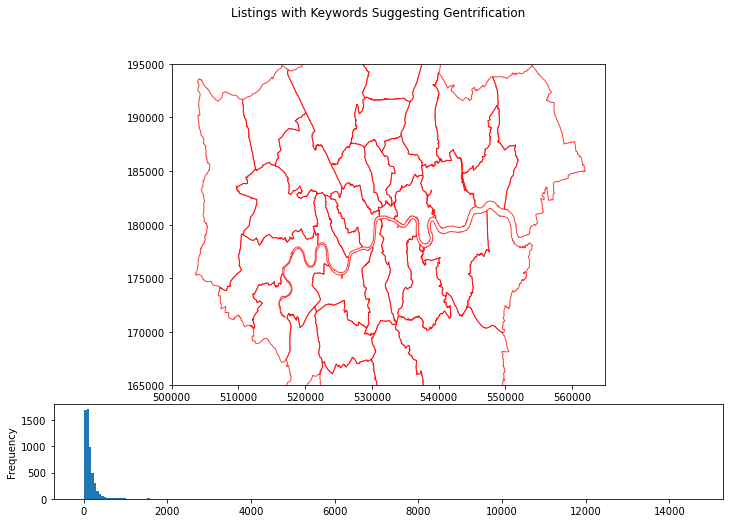

In [63]:
#mapping pt.2
f,ax = plt.subplots(1,1,figsize=(12,8))

# The first plot 
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
gent.plot(markersize=2, column='price', cmap='viridis', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
gent.price.plot.hist(bins=250, ax=ax2)

plt.suptitle("Listings with Keywords Suggesting Gentrification") # <-- How does this differ from title? Change it and see!
plt.show()